## Children vs Adult Classification using DL

Aim: Create a DL model which will identify the children and adults.

Approches that are used in this repository:
1. VGG19
2. ResNet50
3. InceptionV3
4. MobileNetV2

#### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import shutil
from shutil import copyfile

import keras
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator # from keras.preprocessing.image import ImageDataGenerator is deprecated
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import load_img, img_to_array
from keras.applications import VGG19
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Preparing the data

In [3]:
base_dir  = "/Users/omachrekar/My Work/SSOC'23/DL-Simplified/Children vs Adults Classification using DL/Dataset"

In [4]:
mytrain_test_list = []
mylabels_list = []
myitem_list = []
vis_images = []; vis_labels =[]

train_test_list = tf.io.gfile.listdir(base_dir)
for train_test in train_test_list:
    path1 = os.path.join(base_dir, train_test)
    label_list = tf.io.gfile.listdir(path1)
    for label in label_list:
        my_path = os.path.join(path1, label)
        item_files = os.listdir(my_path)

        mytrain_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))
        
        my_files = item_files[0:5]
        for file in my_files:
            vis_images.append(os.path.join(my_path, file))
            vis_labels.append(label)
        
pd.DataFrame({'Tran Test':mytrain_test_list, 'Labels':mylabels_list, \
              'Number of Items':myitem_list})

,Tran Test,Labels,Number of Items
0,test,adults,60
1,test,children,60
2,train,adults,340
3,train,children,340


#### Data Augmentation

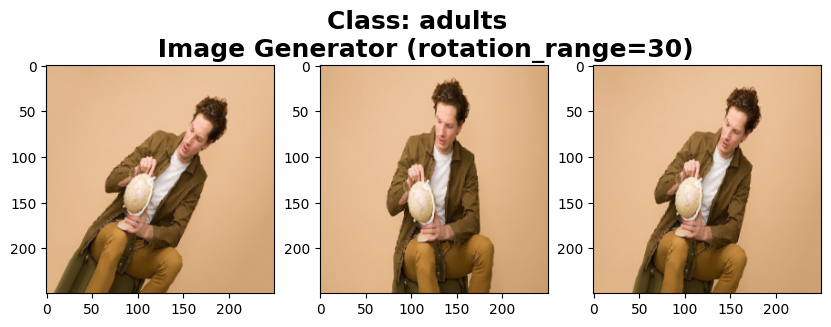

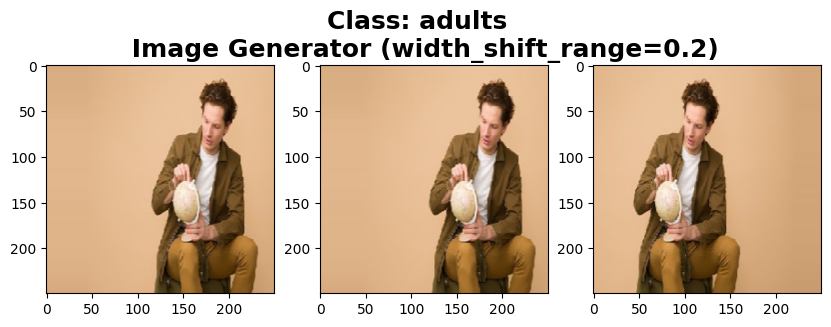

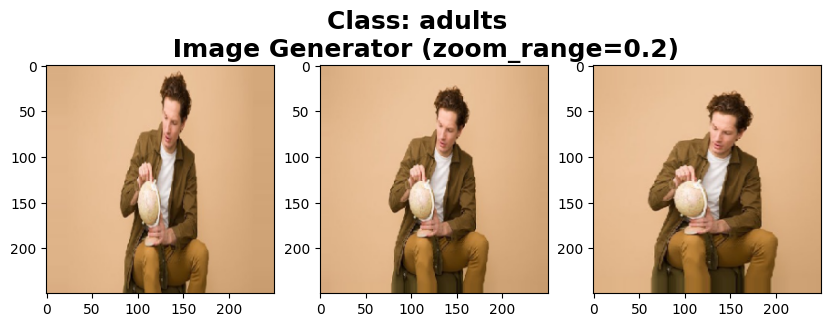

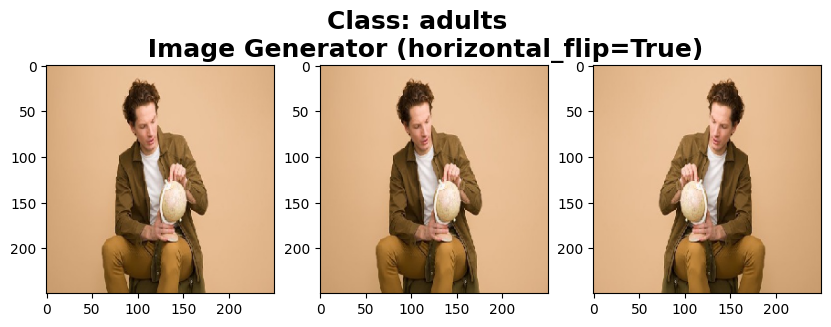

In [5]:
def show_ImageDataGenerator(vis_images, vis_labels, image_index):
    #Loads image in from the set image path
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size= (250,250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    #Creates our batch of one image
    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size =1)
        plt.figure(figsize=(10,3.5))
        #Plots our figures
        for i in range(1,4):
            plt.subplot(1, 3, i)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
        plt.suptitle(f"Class: {class_label} \n Image Generator ({param})",fontsize=18, fontweight='bold')

        plt.show()

    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")

    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")

    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, "zoom_range=0.2")

    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, "horizontal_flip=True")

show_ImageDataGenerator(vis_images, vis_labels, image_index = 3)

In [6]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator

In [7]:
training_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')
print(validation_dir)

/Users/omachrekar/My Work/SSOC'23/DL-Simplified/Children vs Adults Classification using DL/Dataset/test


In [8]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 680 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


#### VGG19 Setup

##### Model Definition:

In [9]:
# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

In [10]:
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: adult and child

In [11]:
# Create the final model
vgg19_model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
vgg19_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

##### Some tuning for learning rate:

In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [14]:
vgg19_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

##### Training:

In [15]:
# Train the model
vgg19_history = vgg19_model.fit(train_generator,
                       epochs=20,
                       validation_data=validation_generator,
                       callbacks=lr_schedule,
                       verbose=1)

Epoch 1/20


2023-06-02 20:50:15.210876: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


22/22 [==============================] - 42s 2s/step - loss: 0.8057 - accuracy: 0.5206 - val_loss: 0.6395 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 2/20
22/22 [==============================] - 42s 2s/step - loss: 0.6754 - accuracy: 0.6265 - val_loss: 0.5855 - val_accuracy: 0.7000 - lr: 1.1220e-04
Epoch 3/20
22/22 [==============================] - 43s 2s/step - loss: 0.6606 - accuracy: 0.6353 - val_loss: 0.5837 - val_accuracy: 0.7000 - lr: 1.2589e-04
Epoch 4/20
22/22 [==============================] - 46s 2s/step - loss: 0.6329 - accuracy: 0.6588 - val_loss: 0.5691 - val_accuracy: 0.7333 - lr: 1.4125e-04
Epoch 5/20
22/22 [==============================] - 44s 2s/step - loss: 0.6057 - accuracy: 0.6985 - val_loss: 0.5625 - val_accuracy: 0.7083 - lr: 1.5849e-04
Epoch 6/20
22/22 [==============================] - 45s 2s/step - loss: 0.5978 - accuracy: 0.6882 - val_loss: 0.5901 - val_accuracy: 0.6583 - lr: 1.7783e-04
Epoch 7/20
22/22 [==============================] - 48s 2s/step - los

##### Performance:

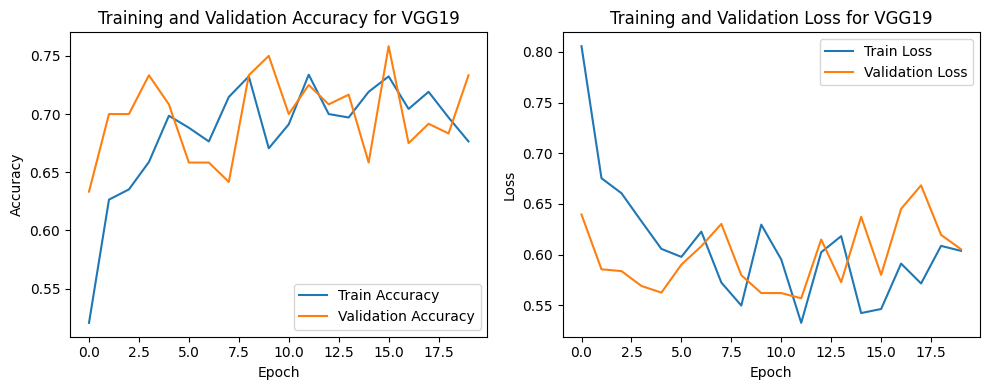

In [16]:
# Extract the metrics from the history
train_accuracy = vgg19_history.history['accuracy']
val_accuracy = vgg19_history.history['val_accuracy']
train_loss = vgg19_history.history['loss']
val_loss = vgg19_history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG19')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG19')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


##### Saving model:

In [17]:
vgg19_model.save('vgg19_model.h5')

##### Prediction:

1/1 [==============================] - 0s 144ms/step
 Class Name: 'adults' Confidence: 53.64


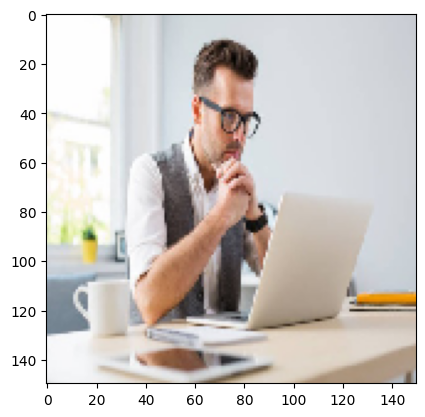

In [18]:
model = tf.keras.models.load_model('vgg19_model.h5')
def make_your_prediction(YOUR_IMAGE_PATH = None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = "/Users/omachrekar/My Work/SSOC'23/DL-Simplified/Children vs Adults Classification using DL/Dataset/test/adults/3.jpg" 
    
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}

    if classes[0]>0.5:
        print(f" Class Name: '{class_name_inverted[1]}' Confidence: {100 * np.max(score):.2f}")
    else:
        print(f" Class Name: '{class_name_inverted[0]}' Confidence: {100 * np.max(score):.2f}")

make_your_prediction(YOUR_IMAGE_PATH = None)

In [ ]:
make_your_prediction("/Users/omachrekar/My Work/SSOC'23/DL-Simplified/Children vs Adults Classification using DL/Dataset/test/children/6.jpg")

In [ ]:
# save model
model.save("model.h5")

#### ResNet50 Setup

##### Model Definition:

In [19]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

In [20]:
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output 
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: adult and child

In [21]:
# create the final model
resnet50_model = Model(inputs=base_model.input, outputs=predictions)
resnet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

##### Some Tuning for learning rate:

In [22]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [23]:
resnet50_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

##### Training:

In [24]:
# Train the model
resnet50_history = model.fit(train_generator,
                       epochs=20,
                       validation_data=validation_generator,
                       callbacks=lr_schedule,
                       verbose=1)

Epoch 1/20
22/22 [==============================] - 42s 2s/step - loss: 0.5227 - accuracy: 0.7279 - val_loss: 0.5952 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 2/20
22/22 [==============================] - 45s 2s/step - loss: 0.5094 - accuracy: 0.7397 - val_loss: 0.5778 - val_accuracy: 0.7250 - lr: 1.1220e-04
Epoch 3/20
22/22 [==============================] - 46s 2s/step - loss: 0.5254 - accuracy: 0.7338 - val_loss: 0.5914 - val_accuracy: 0.7000 - lr: 1.2589e-04
Epoch 4/20
22/22 [==============================] - 44s 2s/step - loss: 0.5016 - accuracy: 0.7632 - val_loss: 0.5794 - val_accuracy: 0.7083 - lr: 1.4125e-04
Epoch 5/20
22/22 [==============================] - 46s 2s/step - loss: 0.4912 - accuracy: 0.7485 - val_loss: 0.5702 - val_accuracy: 0.7500 - lr: 1.5849e-04
Epoch 6/20
22/22 [==============================] - 51s 2s/step - loss: 0.4824 - accuracy: 0.7544 - val_loss: 0.5809 - val_accuracy: 0.7083 - lr: 1.7783e-04
Epoch 7/20
22/22 [==============================] - 52s 2s

##### Performance:

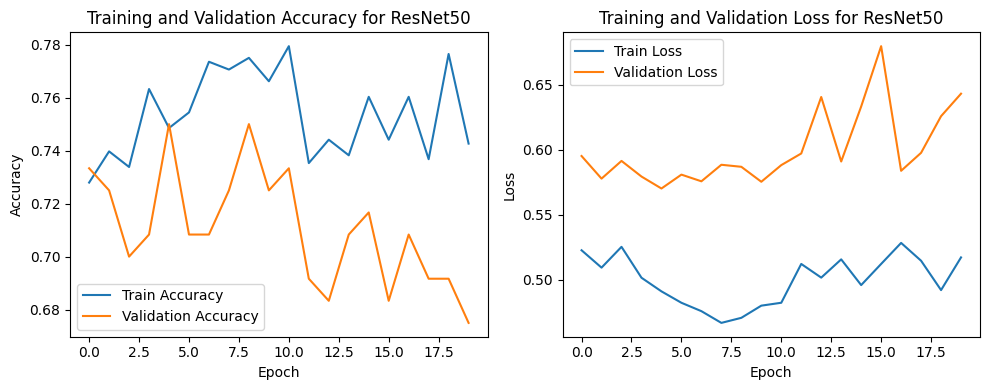

In [38]:
# Extract the metrics from the history
train_accuracy = resnet50_history.history['accuracy']
val_accuracy = resnet50_history.history['val_accuracy']
train_loss = resnet50_history.history['loss']
val_loss = resnet50_history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet50')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


##### Saving model:

In [26]:
resnet50_model.save('resnet50_model.h5')

##### Prediction:

1/1 [==============================] - 0s 397ms/step
 Class Name: 'children' Confidence: 63.61


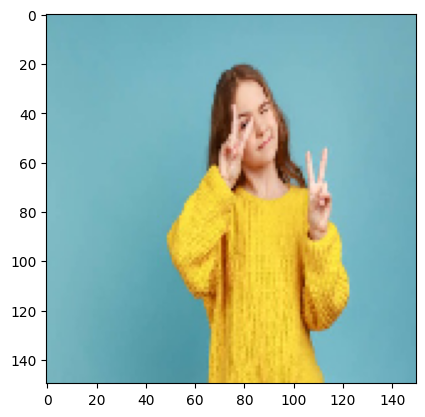

In [29]:
model = tf.keras.models.load_model('resnet50_model.h5')
def make_your_prediction(YOUR_IMAGE_PATH = None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = "/Users/omachrekar/My Work/SSOC'23/DL-Simplified/Children vs Adults Classification using DL/Dataset/test/children/43.jpg" 
    
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}

    if classes[0]>0.5:
        print(f" Class Name: '{class_name_inverted[1]}' Confidence: {100 * np.max(score):.2f}")
    else:
        print(f" Class Name: '{class_name_inverted[0]}' Confidence: {100 * np.max(score):.2f}")

make_your_prediction(YOUR_IMAGE_PATH = None)

#### InceptionV3 Setup

##### Model Definition:

In [30]:
# load the pre-trained inception model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

87910968/87910968 [==============================] - 37s 0us/step


In [31]:
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: adult and child

In [32]:
# Create the final model
inceptionv3_model = Model(inputs=base_model.input, outputs=predictions)

In [33]:
inceptionv3_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

##### Some tuning for learning rate:

In [34]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [35]:
inceptionv3_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

##### Training:

In [37]:
# Train the model
inceptionv3_history = inceptionv3_model.fit(train_generator,
                       epochs=20,
                       validation_data=validation_generator,
                       callbacks=lr_schedule,
                       verbose=1)

Epoch 1/20
22/22 [==============================] - 7s 297ms/step - loss: 0.5111 - accuracy: 0.7426 - val_loss: 0.5653 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 2/20
22/22 [==============================] - 7s 319ms/step - loss: 0.4772 - accuracy: 0.7912 - val_loss: 0.5743 - val_accuracy: 0.7000 - lr: 1.1220e-04
Epoch 3/20
22/22 [==============================] - 7s 326ms/step - loss: 0.4776 - accuracy: 0.7721 - val_loss: 0.5667 - val_accuracy: 0.7167 - lr: 1.2589e-04
Epoch 4/20
22/22 [==============================] - 8s 342ms/step - loss: 0.4555 - accuracy: 0.7897 - val_loss: 0.5577 - val_accuracy: 0.7250 - lr: 1.4125e-04
Epoch 5/20
22/22 [==============================] - 8s 345ms/step - loss: 0.4428 - accuracy: 0.8015 - val_loss: 0.5578 - val_accuracy: 0.7417 - lr: 1.5849e-04
Epoch 6/20
22/22 [==============================] - 8s 356ms/step - loss: 0.4328 - accuracy: 0.8103 - val_loss: 0.5766 - val_accuracy: 0.7083 - lr: 1.7783e-04
Epoch 7/20
22/22 [============================

##### Performance:

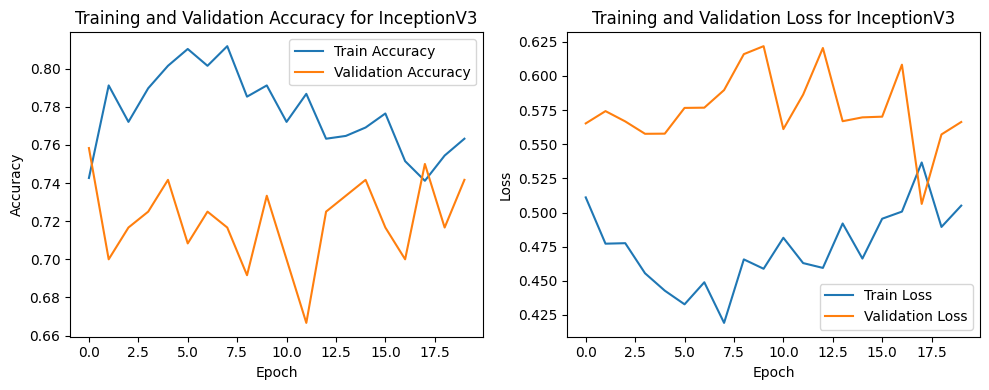

In [39]:
# Extract the metrics from the history
train_accuracy = inceptionv3_history.history['accuracy']
val_accuracy = inceptionv3_history.history['val_accuracy']
train_loss = inceptionv3_history.history['loss']
val_loss = inceptionv3_history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for InceptionV3')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for InceptionV3')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


##### Saving model:

In [40]:
inceptionv3_model.save('inceptionv3_model.h5')

##### Prediction

1/1 [==============================] - 0s 444ms/step
 Class Name: 'children' Confidence: 66.50


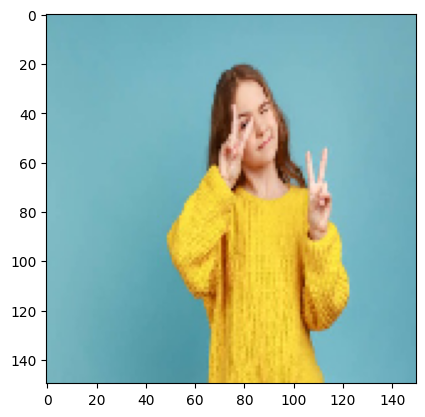

In [41]:
model = tf.keras.models.load_model('inceptionv3_model.h5')
def make_your_prediction(YOUR_IMAGE_PATH = None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = "/Users/omachrekar/My Work/SSOC'23/DL-Simplified/Children vs Adults Classification using DL/Dataset/test/children/43.jpg" 
    
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes =a model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}

    if classes[0]>0.5:
        print(f" Class Name: '{class_name_inverted[1]}' Confidence: {100 * np.max(score):.2f}")
    else:
        print(f" Class Name: '{class_name_inverted[0]}' Confidence: {100 * np.max(score):.2f}")

make_your_prediction(YOUR_IMAGE_PATH = None)

#### MobileNetV2 Setup

##### Model Definition:

In [42]:
# load the pre-trained inception model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

9406464/9406464 [==============================] - 3s 0us/step


In [43]:
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: adult and child

In [45]:
# Create the final model
mobilenetv2_model = Model(inputs=base_model.input, outputs=predictions)

In [46]:
mobilenetv2_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

##### Some tuning for learning rate:

In [47]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [48]:
mobilenetv2_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

##### Training model:

In [49]:
# Train the model
mobilenetv2_history = mobilenetv2_model.fit(train_generator,
                       epochs=20,
                       validation_data=validation_generator,
                       callbacks=lr_schedule,
                       verbose=1)

Epoch 1/20
22/22 [==============================] - 5s 175ms/step - loss: 2.5771 - accuracy: 0.6147 - val_loss: 0.6759 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 2/20
22/22 [==============================] - 3s 151ms/step - loss: 0.8017 - accuracy: 0.7485 - val_loss: 0.5939 - val_accuracy: 0.7917 - lr: 1.1220e-04
Epoch 3/20
22/22 [==============================] - 4s 158ms/step - loss: 0.6557 - accuracy: 0.7500 - val_loss: 0.5371 - val_accuracy: 0.7750 - lr: 1.2589e-04
Epoch 4/20
22/22 [==============================] - 4s 157ms/step - loss: 0.5773 - accuracy: 0.7529 - val_loss: 0.6245 - val_accuracy: 0.7583 - lr: 1.4125e-04
Epoch 5/20
22/22 [==============================] - 3s 151ms/step - loss: 0.5467 - accuracy: 0.7618 - val_loss: 0.5999 - val_accuracy: 0.7417 - lr: 1.5849e-04
Epoch 6/20
22/22 [==============================] - 3s 152ms/step - loss: 0.5118 - accuracy: 0.7838 - val_loss: 0.6873 - val_accuracy: 0.7250 - lr: 1.7783e-04
Epoch 7/20
22/22 [============================

##### Performance:

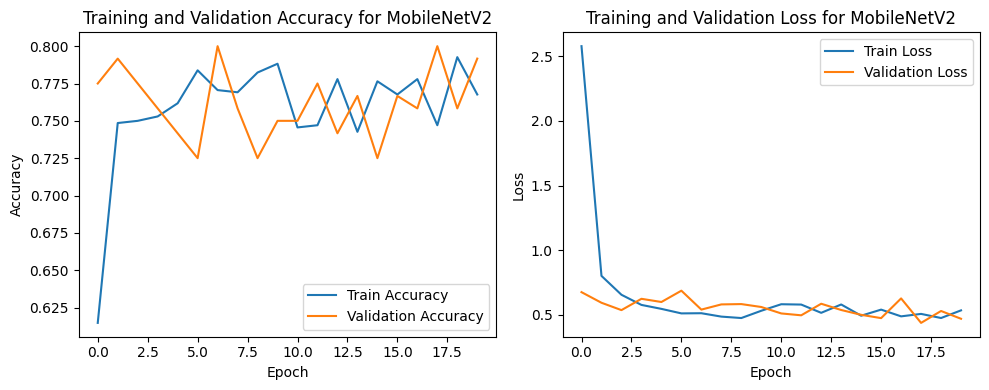

In [51]:
# Extract the metrics from the history
train_accuracy = mobilenetv2_history.history['accuracy']
val_accuracy = mobilenetv2_history.history['val_accuracy']
train_loss = mobilenetv2_history.history['loss']
val_loss = mobilenetv2_history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for MobileNetV2')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for MobileNetV2')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


##### Saving the model:

In [52]:
mobilenetv2_model.save('mobilenetv2_model.h5')

##### Prediction:

1/1 [==============================] - 0s 389ms/step
 Class Name: 'children' Confidence: 67.83


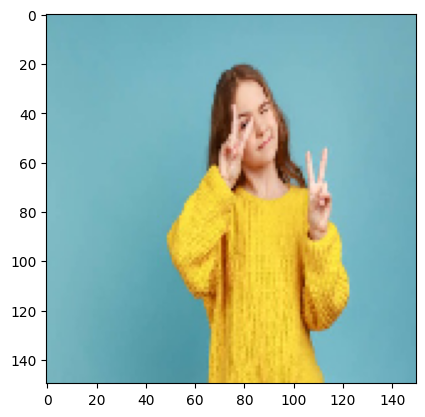

In [54]:
model = tf.keras.models.load_model('mobilenetv2_model.h5')
def make_your_prediction(YOUR_IMAGE_PATH = None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = "/Users/omachrekar/My Work/SSOC'23/DL-Simplified/Children vs Adults Classification using DL/Dataset/test/children/43.jpg" 
    
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes =model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}

    if classes[0]>0.5:
        print(f" Class Name: '{class_name_inverted[1]}' Confidence: {100 * np.max(score):.2f}")
    else:
        print(f" Class Name: '{class_name_inverted[0]}' Confidence: {100 * np.max(score):.2f}")

make_your_prediction(YOUR_IMAGE_PATH = None)

####  Final Comparision:

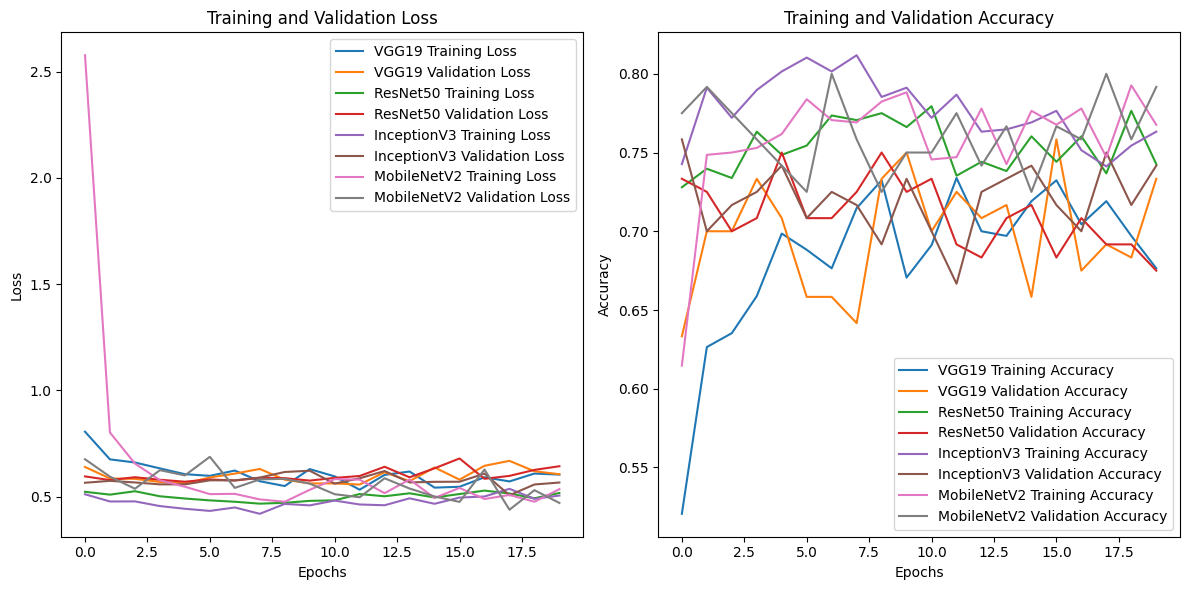

In [55]:
vgg19_history = vgg19_history
resnet50_history = resnet50_history
inceptionv3_history = inceptionv3_history
mobilenetv2_history = mobilenetv2_history

# Plotting the training and validation metrics
plt.figure(figsize=(12, 6))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(vgg19_history.history['loss'], label='VGG19 Training Loss')
plt.plot(vgg19_history.history['val_loss'], label='VGG19 Validation Loss')
plt.plot(resnet50_history.history['loss'], label='ResNet50 Training Loss')
plt.plot(resnet50_history.history['val_loss'], label='ResNet50 Validation Loss')
plt.plot(inceptionv3_history.history['loss'], label='InceptionV3 Training Loss')
plt.plot(inceptionv3_history.history['val_loss'], label='InceptionV3 Validation Loss')
plt.plot(mobilenetv2_history.history['loss'], label='MobileNetV2 Training Loss')
plt.plot(mobilenetv2_history.history['val_loss'], label='MobileNetV2 Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(vgg19_history.history['accuracy'], label='VGG19 Training Accuracy')
plt.plot(vgg19_history.history['val_accuracy'], label='VGG19 Validation Accuracy')
plt.plot(resnet50_history.history['accuracy'], label='ResNet50 Training Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='ResNet50 Validation Accuracy')
plt.plot(inceptionv3_history.history['accuracy'], label='InceptionV3 Training Accuracy')
plt.plot(inceptionv3_history.history['val_accuracy'], label='InceptionV3 Validation Accuracy')
plt.plot(mobilenetv2_history.history['accuracy'], label='MobileNetV2 Training Accuracy')
plt.plot(mobilenetv2_history.history['val_accuracy'], label='MobileNetV2 Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


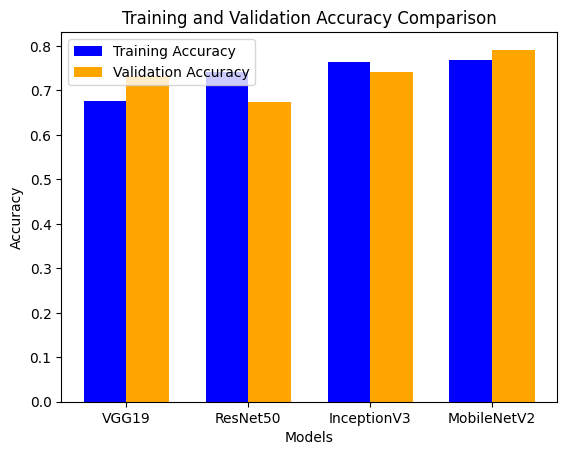

In [56]:
# Extract the training and validation accuracy values from the history object
vgg19_train_acc = vgg19_history.history['accuracy']
vgg19_val_acc = vgg19_history.history['val_accuracy']
resnet50_train_acc = resnet50_history.history['accuracy']
resnet50_val_acc = resnet50_history.history['val_accuracy']
inceptionv3_train_acc = inceptionv3_history.history['accuracy']
inceptionv3_val_acc = inceptionv3_history.history['val_accuracy']
mobilenetv2_train_acc = mobilenetv2_history.history['accuracy']
mobilenetv2_val_acc = mobilenetv2_history.history['val_accuracy']

# Model names
models = ['VGG19', 'ResNet50', 'InceptionV3', 'MobileNetV2']

# Training and validation accuracy values
training_acc = [vgg19_train_acc[-1], resnet50_train_acc[-1], inceptionv3_train_acc[-1], mobilenetv2_train_acc[-1]]
validation_acc = [vgg19_val_acc[-1], resnet50_val_acc[-1], inceptionv3_val_acc[-1], mobilenetv2_val_acc[-1]]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Create the bar plots
plt.bar(r1, training_acc, color='blue', width=bar_width, label='Training Accuracy')
plt.bar(r2, validation_acc, color='orange', width=bar_width, label='Validation Accuracy')

# Add labels, title, and x-axis ticks
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)

plt.legend()
plt.show()


In [57]:
# print the val accuracy for each model
print("VGG19 Validation Accuracy: {}".format(vgg19_val_acc[-1]))
print("ResNet50 Validation Accuracy: {}".format(resnet50_val_acc[-1]))
print("InceptionV3 Validation Accuracy: {}".format(inceptionv3_val_acc[-1]))
print("MobileNetV2 Validation Accuracy: {}".format(mobilenetv2_val_acc[-1]))

VGG19 Validation Accuracy: 0.7333333492279053
ResNet50 Validation Accuracy: 0.675000011920929
InceptionV3 Validation Accuracy: 0.7416666746139526
MobileNetV2 Validation Accuracy: 0.7916666865348816
